In [1]:
import MDAnalysis as mda
import MDAnalysis.transformations as trans
from MDAnalysis.analysis import align
import MDAnalysis.analysis.rms as rms
import numpy as np
from MDAnalysis.tests.datafiles import CRD, PSF, DCD, DCD2

In [15]:
def traj_align(psf, xtc, out_xtc, center=True):
    """
    psf: PSF; TPR for the simulation system;
    xtc: XTC or DCD format;
    out_xtc: aligned output trajectory path;
    center: whether center the protein to the center of the box;

    !!! default: align the trajectory with respect to the first frame [hard coded!]
    return None
    """
    u = mda.Universe(psf, xtc)
    ref = mda.Universe(psf, xtc)
    ref.trajectory[0]

    # Center protein in the center of the box
    if center:
        protein = u.select_atoms('protein')
        not_protein = u.select_atoms('not protein')
        for ts in u.trajectory:
            protein.unwrap(compound='fragments')
            protein_center = protein.center_of_mass(pbc=True)
            dim = ts.triclinic_dimensions
            box_center = np.sum(dim, axis=0) / 2
            # translate all atoms
            u.atoms.translate(box_center - protein_center)
            # wrap all solvent part back to the box
            not_protein.wrap(compound='residues')
            
    # align using C-alpha atoms
    align.AlignTraj(u, # universe object; trajectory to align
                    ref, # reference
                    select='name CA', # selection of atoms to align
                    filename=out_xtc, 
                    match_atoms=True, 
                   ).run()

    return None


In [12]:
adk_open = mda.Universe(CRD, DCD2)
adk_closed = mda.Universe(PSF, DCD)

/home/jianhuang/miniconda3/envs/mda/lib/python3.9/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [16]:
traj_align(PSF, DCD, "./tmp/test.xtc", center=False)

In [21]:
u = mda.Universe(PSF, DCD)
view = nv.show_mdanalysis(u)
view.add_representation('point', 'resname SOL')
view.center()
view

/home/jianhuang/miniconda3/envs/mda/lib/python3.9/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


NGLWidget(max_frame=97)

In [22]:
u = mda.Universe(PSF, "./tmp/test.xtc")
view = nv.show_mdanalysis(u)
view.add_representation('point', 'resname SOL')
view.center()
view

/home/jianhuang/miniconda3/envs/mda/lib/python3.9/site-packages/MDAnalysis/lib/mdamath.py:295: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.rad2deg(np.arccos(np.dot(y, z) / (ly * lz)))
/home/jianhuang/miniconda3/envs/mda/lib/python3.9/site-packages/MDAnalysis/lib/mdamath.py:296: RuntimeWarning: invalid value encountered in scalar divide
  beta = np.rad2deg(np.arccos(np.dot(x, z) / (lx * lz)))
/home/jianhuang/miniconda3/envs/mda/lib/python3.9/site-packages/MDAnalysis/lib/mdamath.py:297: RuntimeWarning: invalid value encountered in scalar divide
  gamma = np.rad2deg(np.arccos(np.dot(x, y) / (lx * ly)))


NGLWidget(max_frame=97)

In [23]:
def traj_align_onfly(psf, xtc, out_xtc, center=True):
    """
    psf: PSF; TPR for the simulation system;
    xtc: XTC or DCD format;
    out_xtc: aligned output trajectory path;
    center: whether center the protein to the center of the box;

    !!! default: align the trajectory with respect to the first frame [hard coded!]
    return None
    """
    u = mda.Universe(psf, xtc)
    ref = mda.Universe(psf, xtc)
    ref.trajectory[0]
    if center:
        protein = u.select_atoms('protein')
        not_protein = u.select_atoms('not protein')
        transforms = [trans.unwrap(protein),
                trans.center_in_box(protein, wrap=True),
                trans.wrap(not_protein)]

        u.trajectory.add_transformations(*transforms)

    # align using C-alpha atoms
    align.AlignTraj(u, # universe object; trajectory to align
                    ref, # reference
                    select='name CA', # selection of atoms to align
                    filename=out_xtc,
                    match_atoms=True,
                   ).run()

    return None


In [24]:
traj_align(PSF, DCD, "./tmp/test2.xtc", center=False)
u = mda.Universe(PSF, "./tmp/test2.xtc")
view = nv.show_mdanalysis(u)
view.add_representation('point', 'resname SOL')
view.center()
view

/home/jianhuang/miniconda3/envs/mda/lib/python3.9/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


NGLWidget(max_frame=97)

In [37]:
psf, xtc = PSF, DCD
u = mda.Universe(psf, xtc)
ref = mda.Universe(psf, xtc)
R = rms.RMSD(u, ref, select="name CA", groupselections=["protein",])
R.run()


/home/jianhuang/miniconda3/envs/mda/lib/python3.9/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


Text(0, 0.5, 'RMSD ($\\AA$)')

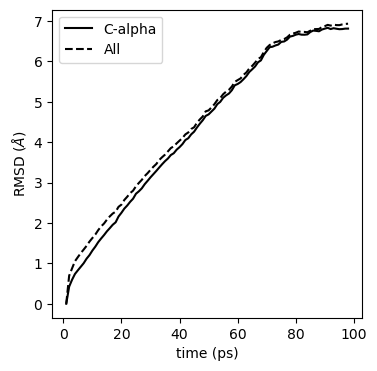

In [48]:
import matplotlib.pyplot as plt
rmsd = R.rmsd.T   # transpose makes it easier for plotting
time = rmsd[1]
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(time, rmsd[2], 'k-',  label="C-alpha")
ax.plot(time, rmsd[3], 'k--', label="All")
# ax.plot(time, rmsd[4], 'r--', label="LID")
# ax.plot(time, rmsd[5], 'b--', label="NMP")
ax.legend(loc="best")
ax.set_xlabel("time (ps)")
ax.set_ylabel(r"RMSD ($\AA$)")

# Mapping backbone dihedrals to BAT matrix

In [2]:
import MDAnalysis as mda
from MDAnalysis.analysis.bat import BAT
from MDAnalysis.analysis import dihedrals
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import itertools

In [3]:
psf = "test.psf"
xtc = "pro_align.xtc"

u = mda.Universe(psf, xtc)

In [4]:
u.trajectory

<XTCReader pro_align.xtc with 20001 frames of 855 atoms>

In [8]:
selection = u.select_atoms("protein")
R = BAT(selection)
R.run(start=0, stop=10, step=1)


In [19]:
R.results.bat

(10, 2565)

In [14]:
bonds = R.results.bat[:, 9:len(u.atoms)-3+9]
angles = R.results.bat[:, len(u.atoms)-3+9:(len(u.atoms)-3)*2+9]
dihedrals = R.results.bat[:, (len(u.atoms)-3)*2+9:]


In [21]:
bonds.shape

(10, 852)

In [22]:
angles.shape

(10, 852)

In [23]:
dihedrals.shape

(10, 852)

In [30]:
test = R._torsions[0]


In [35]:
for i in list(test.atoms):
    print(i)


[<Atom 843: HA of type HB1 of resname GLU, resid 56 and segid PROA>,
 <Atom 842: CA of type CT1 of resname GLU, resid 56 and segid PROA>,
 <Atom 853: C of type CC of resname GLU, resid 56 and segid PROA>,
 <Atom 855: OT2 of type OC of resname GLU, resid 56 and segid PROA>]

In [36]:
atom0 = list(test.atoms)[0]

In [38]:
atom0.name

'HA'

In [49]:
for idx, tor in enumerate(R._torsions):
    atom0, atom1, atom2, atom3 = list(tor)
    print(atom0.name, atom1.name, atom2.name, atom3.name)
    # if atom0.name == "C" and atom1.name == "N": # and atom2.name == "CA" and atom3.name == "C":
    #     print(list(tor))

HA CA C OT2
CB CA C OT2
HB1 CB CA HA
HB2 CB CA HA
CG CB CA HA
HG1 CG CB HB1
HG2 CG CB HB1
CD CG CB HB1
OE1 CD CG HG1
OE2 CD CG HG1
OT1 C CA HA
N CA CB HB1
HN N CA HA
C N CA HA
CA C N HN
HA CA C N
CB CA C N
HB CB CA HA
CG2 CB CA HA
OG1 CB CA HA
HG21 CG2 CB HB
HG22 CG2 CB HB
HG23 CG2 CB HB
HG1 OG1 CB HB
O C CA HA
N CA CB HB
HN N CA HA
C N CA HA
CA C N HN
HA CA C N
CB CA C N
HB CB CA HA
CG1 CB CA HA
CG2 CB CA HA
HG11 CG1 CB HB
HG12 CG1 CB HB
HG13 CG1 CB HB
HG21 CG2 CB HB
HG22 CG2 CB HB
HG23 CG2 CB HB
O C CA HA
N CA CB HB
HN N CA HA
C N CA HA
CA C N HN
HA CA C N
CB CA C N
HB CB CA HA
CG2 CB CA HA
OG1 CB CA HA
HG21 CG2 CB HB
HG22 CG2 CB HB
HG23 CG2 CB HB
HG1 OG1 CB HB
O C CA HA
N CA CB HB
HN N CA HA
C N CA HA
CA C N HN
HA CA C N
CB CA C N
HB1 CB CA HA
HB2 CB CA HA
CG CB CA HA
CD1 CG CB HB1
CD2 CG CB HB1
HD1 CD1 CG CB
CE1 CD1 CG CB
HD2 CD2 CG CB
CE2 CD2 CG CB
HE1 CE1 CD1 HD1
CZ CE1 CD1 HD1
HE2 CE2 CZ CE1
HZ CZ CE1 HE1
O C CA HA
N CA CB HB1
HN N CA HA
C N CA HA
CA C N HN
HA CA C N
CB CA C N
H

**NO backbone torsion in BAR matrix**

# change backbond dihedral in Biopython

In [50]:
from Bio.PDB import PDBParser, PICIO, PDBIO
from Bio.PDB.internal_coords import *
from Bio.PDB.PICIO import write_PIC, read_PIC, read_PIC_seq
from Bio.PDB.ic_rebuild import write_PDB, IC_duplicate, structure_rebuild_test


# functions
def get_dihedral(pdb):
    parser = PDBParser(PERMISSIVE=1, QUIET=1)
    structure = parser.get_structure("test", pdb)[0]

    structure.atom_to_internal_coordinates()
    chain = list(structure.get_chains())[0]
    ic_chain = chain.internal_coord
    return ic_chain.dihedra

def reconstructPDB(pic_file, pdb_output):
    myprotein = read_PIC(pic_file, verbose=1)
    myprotein.internal_to_atom_coordinates()
    write_PDB(myprotein, pdb_output)
    return None


In [52]:
parser = PDBParser(PERMISSIVE=1, QUIET=1)
structure = parser.get_structure("test", "../test/files/test.pdb")[0]

structure.atom_to_internal_coordinates()
chain = list(structure.get_chains())[0]
ic_chain = chain.internal_coord
d = ic_chain.dihedra


In [61]:
phi = []
psi = []
for i in list(d.keys()):
    atom0, atom1, atom2, atom3 = list(i)
    if atom0.id.endswith('C') and atom1.id.endswith('N') and atom2.id.endswith('CA') and atom3.id.endswith('C'):
        phi.append(i)
    if atom0.id.endswith('N') and atom1.id.endswith('CA') and atom2.id.endswith('C') and atom3.id.endswith('N'):
        psi.append(i)

In [86]:
results = []
for res in structure.get_residues():
    phi = res.internal_coord.get_angle("phi")
    psi = res.internal_coord.get_angle("psi")
    print(phi, psi)
    results.append((phi, psi))

None None
None 119.58094695021427
-112.90835097176408 147.80661251770556
-126.94171080082674 137.79616941482436
-115.0530768475688 132.57738913389372
-104.64097597523524 119.36466198684998
-93.50182947354267 107.04040521862011
-104.9174679469285 74.24495565799486
-86.42980701843561 162.34541203842957
-61.90854092405597 -43.55325238995319
-133.4691754893968 -9.216514681983949
-108.8999013704468 105.93573305754963
-121.52882849973155 147.9539095993497
159.1938788830489 172.1410868759756
-149.18162300993592 144.45355219046675
-152.17198888706017 156.50650979649035
-140.65453645358056 155.1288323735647
-164.5934276937371 150.69807694949276
-99.47839856886873 123.6040798192373
-140.31613244668463 150.77583166524877
-77.84567805874715 -18.604846024193908
-153.02405685609847 157.37828160891533
-56.8146999341478 -36.86684900839667
-56.11492085000423 -42.889672629379014
-64.33171098971647 -30.57591907266497
-83.73188985014541 -21.638390863592914
-58.57884431085106 -47.16657431611554
-67.6424699

In [131]:
parser = PDBParser(PERMISSIVE=1, QUIET=1)
structure = parser.get_structure("test", "/home2/jianhuang/Downloads/1ubq.pdb")[0]

structure.atom_to_internal_coordinates()
chain = list(structure.get_chains())[0]
ic_chain = chain.internal_coord
d = ic_chain.dihedra

# phis = []
for res in list(structure.get_residues())[:76]:
    print(res.id, res.internal_coord.pick_angle("phi"))
    # phis.append(res.internal_coord.get_angle("phi"))

(' ', 1, ' ') None
(' ', 2, ' ') 4-1_M_C:2_Q_N:2_Q_CA:2_Q_C MCQNQCAQC -91.02024967483344 ('test', 0, 'A', (' ', 1, ' '))
(' ', 3, ' ') 4-2_Q_C:3_I_N:3_I_CA:3_I_C QCINICAIC -131.09890385004456 ('test', 0, 'A', (' ', 2, ' '))
(' ', 4, ' ') 4-3_I_C:4_F_N:4_F_CA:4_F_C ICFNFCAFC -115.99120984786789 ('test', 0, 'A', (' ', 3, ' '))
(' ', 5, ' ') 4-4_F_C:5_V_N:5_V_CA:5_V_C FCVNVCAVC -118.03034252851447 ('test', 0, 'A', (' ', 4, ' '))
(' ', 6, ' ') 4-5_V_C:6_K_N:6_K_CA:6_K_C VCKNKCAKC -95.22607581845006 ('test', 0, 'A', (' ', 5, ' '))
(' ', 7, ' ') 4-6_K_C:7_T_N:7_T_CA:7_T_C KCTNTCATC -99.57961211013068 ('test', 0, 'A', (' ', 6, ' '))
(' ', 8, ' ') 4-7_T_C:8_L_N:8_L_CA:8_L_C TCLNLCALC -73.42523323546897 ('test', 0, 'A', (' ', 7, ' '))
(' ', 9, ' ') 4-8_L_C:9_T_N:9_T_CA:9_T_C LCTNTCATC -101.39710286902451 ('test', 0, 'A', (' ', 8, ' '))
(' ', 10, ' ') 4-9_T_C:10_G_N:10_G_CA:10_G_C TCGNGCAGC 77.44471502137687 ('test', 0, 'A', (' ', 9, ' '))
(' ', 11, ' ') 4-10_G_C:11_K_N:11_K_CA:11_K_C GCKNKCAKC 

In [148]:
parser = PDBParser(PERMISSIVE=1, QUIET=1)
structure = parser.get_structure("test", "../test/files/step1_pdbreader.pdb")[0]

structure.atom_to_internal_coordinates()
chain = list(structure.get_chains())[0]
ic_chain = chain.internal_coord
d = ic_chain.dihedra

phis_good = []
for res in list(structure.get_residues()):
    print(res.internal_coord.pick_angle("phi"))
    phis_good.append(res.internal_coord.get_angle("phi"))

None
4-1_M_C:2_T_N:2_T_CA:2_T_C MCTNTCATC -90.70432416396112 ('test', 0, 'P', (' ', 1, ' '))
4-2_T_C:3_Y_N:3_Y_CA:3_Y_C TCYNYCAYC -113.15422541041421 ('test', 0, 'P', (' ', 2, ' '))
4-3_Y_C:4_K_N:4_K_CA:4_K_C YCKNKCAKC -115.55777880786889 ('test', 0, 'P', (' ', 3, ' '))
4-4_K_C:5_L_N:5_L_CA:5_L_C KCLNLCALC -120.13558272284689 ('test', 0, 'P', (' ', 4, ' '))
4-5_L_C:6_I_N:6_I_CA:6_I_C LCINICAIC -107.77446605098622 ('test', 0, 'P', (' ', 5, ' '))
4-6_I_C:7_L_N:7_L_CA:7_L_C ICLNLCALC -103.87039049870549 ('test', 0, 'P', (' ', 6, ' '))
4-7_L_C:8_N_N:8_N_CA:8_N_C LCNNNCANC -111.59027599989274 ('test', 0, 'P', (' ', 7, ' '))
4-8_N_C:9_G_N:9_G_CA:9_G_C NCGNGCAGC -71.9844490774013 ('test', 0, 'P', (' ', 8, ' '))
4-9_G_C:10_K_N:10_K_CA:10_K_C GCKNKCAKC -63.75057335114557 ('test', 0, 'P', (' ', 9, ' '))
4-10_K_C:11_T_N:11_T_CA:11_T_C KCTNTCATC -118.49521477478365 ('test', 0, 'P', (' ', 10, ' '))
4-11_T_C:12_L_N:12_L_CA:12_L_C TCLNLCALC -98.22738366762968 ('test', 0, 'P', (' ', 11, ' '))
4-12_L_C

In [154]:
parser = PDBParser(PERMISSIVE=1, QUIET=1)
structure = parser.get_structure("test", "../test/files/bad.pdb")[0]

structure.atom_to_internal_coordinates()
# chain = list(structure.get_chains())[0]
# ic_chain = chain.internal_coord
# d = ic_chain.dihedra

phis_bio = []
for res in list(structure.get_residues()):
    print(res.internal_coord.pick_angle("phi"))
    phis_bio.append(res.internal_coord.get_angle("phi"))

None
None
4-2_T_C:3_Y_N:3_Y_CA:3_Y_C TCYNYCAYC -112.90835097176408 ('test', 0, 'P', (' ', 2, ' '))
4-3_Y_C:4_K_N:4_K_CA:4_K_C YCKNKCAKC -126.94171080082674 ('test', 0, 'P', (' ', 3, ' '))
4-4_K_C:5_L_N:5_L_CA:5_L_C KCLNLCALC -115.0530768475688 ('test', 0, 'P', (' ', 4, ' '))
4-5_L_C:6_I_N:6_I_CA:6_I_C LCINICAIC -104.64097597523524 ('test', 0, 'P', (' ', 5, ' '))
4-6_I_C:7_L_N:7_L_CA:7_L_C ICLNLCALC -93.50182947354267 ('test', 0, 'P', (' ', 6, ' '))
4-7_L_C:8_N_N:8_N_CA:8_N_C LCNNNCANC -104.9174679469285 ('test', 0, 'P', (' ', 7, ' '))
4-8_N_C:9_G_N:9_G_CA:9_G_C NCGNGCAGC -86.42980701843561 ('test', 0, 'P', (' ', 8, ' '))
4-9_G_C:10_K_N:10_K_CA:10_K_C GCKNKCAKC -61.90854092405597 ('test', 0, 'P', (' ', 9, ' '))
4-10_K_C:11_T_N:11_T_CA:11_T_C KCTNTCATC -133.4691754893968 ('test', 0, 'P', (' ', 10, ' '))
4-11_T_C:12_L_N:12_L_CA:12_L_C TCLNLCALC -108.8999013704468 ('test', 0, 'P', (' ', 11, ' '))
4-12_L_C:13_K_N:13_K_CA:13_K_C LCKNKCAKC -121.52882849973155 ('test', 0, 'P', (' ', 12, ' '))


In [155]:
u = mda.Universe("../test/files/test.pdb")
protein = u.select_atoms("protein")
phis = [res.phi_selection() for res in protein.residues[1:]]
from MDAnalysis.analysis import dihedrals
phis_value = dihedrals.Dihedral(phis).run()
phis_value.angles

/home/jianhuang/miniconda3/envs/mda/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/jianhuang/miniconda3/envs/mda/lib/python3.9/site-packages/MDAnalysis/analysis/base.py:447: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time
/home/jianhuang/miniconda3/envs/mda/lib/python3.9/site-packages/MDAnalysis/analysis/dihedrals.py:322: DeprecationWarning: The `angle` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.angles` instead
  warnings.warn(wmsg, DeprecationWarning)


array([[ -77.00298991, -112.90835097, -126.9417108 , -115.05307685,
        -104.64097598,  -93.50182947, -104.91746795,  -86.42980702,
         -61.90854092, -133.46917549, -108.89990137, -121.5288285 ,
         159.19387888, -149.18162301, -152.17198889, -140.65453645,
        -164.59342769,  -99.47839857, -140.31613245,  -77.84567806,
        -153.02405686,  -56.81469993,  -56.11492085,  -64.33171099,
         -83.73188985,  -58.57884431,  -67.64246996,  -54.96821641,
         -70.05317442,  -56.96301174,  -63.47466827,  -62.10167648,
         -55.10796455,  -80.14131315,  -85.44127426, -113.10096265,
          80.22890416,  -89.61321   , -133.67165044,  179.29456469,
        -104.92877307,  -94.81536619, -131.69858002, -135.55375705,
         -97.77180989,  -75.7378247 ,  -57.49875877, -103.27811737,
          62.78003154, -123.42979081,  -78.87330626, -135.59781923,
        -125.10939022, -136.3262087 ,  -82.82191272]])

In [152]:
phis_good

[None,
 -90.70432416396112,
 -113.15422541041421,
 -115.55777880786889,
 -120.13558272284689,
 -107.77446605098622,
 -103.87039049870549,
 -111.59027599989274,
 -71.9844490774013,
 -63.75057335114557,
 -118.49521477478365,
 -98.22738366762968,
 -131.8278016153817,
 179.8368328709307,
 -148.06964075976154,
 -156.3558865836202,
 -133.6524693270919,
 -156.34895290111191,
 -102.87036151704415,
 -149.46491610719218,
 -60.01485225659656,
 -159.93516252431695,
 -68.74267709073045,
 -57.3398955813898,
 -70.15176211915545,
 -59.82122677985009,
 -56.13906242676926,
 -63.834989042454346,
 -67.67975014115537,
 -63.800329020508066,
 -60.52221831310995,
 -67.3278566285713,
 -59.97753905486435,
 -61.188316974760845,
 -61.99817530630624,
 -60.662808706477556,
 -95.91852232215197,
 67.22658917295725,
 -109.90563565707882,
 -132.9288626034969,
 -177.43996971180584,
 -91.81603610563744,
 -96.68581964579847,
 -131.67828951509122,
 -134.76284642949136,
 -112.03740854421305,
 -66.35176213174658,
 -63.860675